In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import lightgbm as lgb


In [69]:
import pandas as pd
df = pd.read_csv('matches.csv')
df.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [70]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date').reset_index(drop=True)
df['team1_win'] = (df['winner'] == df['team1']).astype(int)
le = LabelEncoder()
df['team1_enc'] = le.fit_transform(df['team1'])
df['team2_enc'] = le.fit_transform(df['team2'])
df['toss_win_match_win'] = (df['toss_winner'] == df['winner']).astype(int)


In [71]:
match_results = []
for _, row in df.iterrows():
    winner = row['winner']
    loser = row['team2'] if row['team1'] == winner else row['team1']
    match_results.append({'team': row['team1'], 'date': row['date'], 'won': int(row['team1'] == winner)})
    match_results.append({'team': row['team2'], 'date': row['date'], 'won': int(row['team2'] == winner)})

team_history = pd.DataFrame(match_results)
team_history['rolling_win_pct'] = (
    team_history.groupby("team")["won"]
    .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)


In [72]:
df = df.merge(
    team_history[['team', 'date', 'rolling_win_pct']],
    left_on=['team1', 'date'],
    right_on=['team', 'date'],
    how='left'
).rename(columns={'rolling_win_pct': 'team1_recent_win_pct'}).drop(columns='team')

df = df.merge(
    team_history[['team', 'date', 'rolling_win_pct']],
    left_on=['team2', 'date'],
    right_on=['team', 'date'],
    how='left'
).rename(columns={'rolling_win_pct': 'team2_recent_win_pct'}).drop(columns='team')


In [73]:
mask = df['team1_recent_win_pct'].notna() & df['team2_recent_win_pct'].notna()
df_filtered = df[mask].reset_index(drop=True)

X = df_filtered[[
    'team1_enc',
    'team2_enc',
    'toss_win_match_win',
    'team1_recent_win_pct',
    'team2_recent_win_pct'
]]
y = df_filtered['team1_win']


In [74]:
X = X.fillna(0.5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")


[LightGBM] [Info] Number of positive: 258, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 595, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433613 -> initscore=-0.267123
[LightGBM] [Info] Start training from score -0.267123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [75]:
home_venues = pd.read_csv('teamwise_home_and_away.csv')
home_venues.head()

,team,home_wins,away_wins,home_matches,away_matches,home_win_percentage,away_win_percentage
0,Rising Pune Supergiant,5,5,8,8,62.500000,62.500000
1,Mumbai Indians,58,51,101,86,57.425743,59.302326
2,Chennai Super Kings,51,49,89,75,57.303371,65.333333
3,Delhi Capitals,3,7,6,10,50.000000,70.000000
4,Sunrisers Hyderabad,30,28,63,45,47.619048,62.222222


In [77]:
home_ground_map = {
    'Mumbai Indians': 'Wankhede Stadium',
    'Chennai Super Kings': 'MA Chidambaram Stadium',
    'Royal Challengers Bangalore': 'M Chinnaswamy Stadium',
    'Kolkata Knight Riders': 'Eden Gardens',
    'Delhi Capitals': 'Arun Jaitley Stadium',
    'Sunrisers Hyderabad': 'Rajiv Gandhi International Stadium',
    'Rajasthan Royals': 'Sawai Mansingh Stadium',
    'Punjab Kings': 'Punjab Cricket Association IS Bindra Stadium',
    'Gujarat Titans': 'Narendra Modi Stadium',
    'Lucknow Super Giants': 'BRSABV Ekana Cricket Stadium',
}
df['team1_home_venue'] = df['team1'].map(home_ground_map)
df['team1_home'] = (df['venue'] == df['team1_home_venue']).astype(int)


In [79]:
df = df.merge(home_venues, left_on='team1', right_on='team', how='left')
df = df.rename(columns={'home_venue': 'team1_home_venue'})
df = df.drop(columns='team')
df['team1_home'] = (df['venue'] == df['team1_home_venue']).astype(int)


In [80]:
mask = df['team1_recent_win_pct'].notna() & df['team2_recent_win_pct'].notna()
df_filtered = df[mask].reset_index(drop=True)
X = df_filtered[[
    'team1_enc',
    'team2_enc',
    'toss_win_match_win',
    'team1_recent_win_pct',
    'team2_recent_win_pct',
    'team1_home'
]]
y = df_filtered['team1_win']

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = X.fillna(0.5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Model Accuracy with home advantage: {accuracy_score(y_test, y_pred):.2f}")


[LightGBM] [Info] Number of positive: 258, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 595, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433613 -> initscore=-0.267123
[LightGBM] [Info] Start training from score -0.267123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [83]:
batting_df = pd.read_csv('most_runs_average_strikerate.csv')
batting_df.columns


Index(['batsman', 'total_runs', 'out', 'numberofballs', 'average',
       'strikerate'],
      dtype='object')

In [84]:
batting_df = pd.read_csv('most_runs_average_strikerate.csv')
batting_df = batting_df.dropna(subset=['average', 'strikerate'])
batting_df['average'] = pd.to_numeric(batting_df['average'], errors='coerce')
batting_df['strikerate'] = pd.to_numeric(batting_df['strikerate'], errors='coerce')
batting_df['batting_score'] = batting_df['average'] * batting_df['strikerate']


In [86]:
batsman_team_map = {
    'Virat Kohli': 'Royal Challengers Bangalore',
    'Faf du Plessis': 'Royal Challengers Bangalore',
    'Glenn Maxwell': 'Royal Challengers Bangalore',
    'Ruturaj Gaikwad': 'Chennai Super Kings',
    'MS Dhoni': 'Chennai Super Kings',
    'Shivam Dube': 'Chennai Super Kings',
    'David Warner': 'Delhi Capitals',
    'Prithvi Shaw': 'Delhi Capitals',
    'Rishabh Pant': 'Delhi Capitals',
    'Rohit Sharma': 'Mumbai Indians',
    'Ishan Kishan': 'Mumbai Indians',
    'Suryakumar Yadav': 'Mumbai Indians',
    'Jos Buttler': 'Rajasthan Royals',
    'Sanju Samson': 'Rajasthan Royals',
    'Yashasvi Jaiswal': 'Rajasthan Royals',
    'KL Rahul': 'Lucknow Super Giants',
    'Quinton de Kock': 'Lucknow Super Giants',
    'Marcus Stoinis': 'Lucknow Super Giants',
    'Hardik Pandya': 'Gujarat Titans',
    'Shubman Gill': 'Gujarat Titans',
    'David Miller': 'Gujarat Titans',
    'Shikhar Dhawan': 'Punjab Kings',
    'Liam Livingstone': 'Punjab Kings',
    'Jonny Bairstow': 'Punjab Kings',
    'Andre Russell': 'Kolkata Knight Riders',
    'Nitish Rana': 'Kolkata Knight Riders',
    'Rinku Singh': 'Kolkata Knight Riders',
    'Rahul Tripathi': 'Sunrisers Hyderabad',
    'Aiden Markram': 'Sunrisers Hyderabad',
    'Abhishek Sharma': 'Sunrisers Hyderabad',
}
batting_df['team'] = batting_df['batsman'].map(batsman_team_map)
batting_df = batting_df.dropna(subset=['team'])


In [87]:
top_batsmen = (
    batting_df.groupby('team')
    .apply(lambda x: x.nlargest(5, 'batting_score'))
    .reset_index(drop=True)
)
team_batting_strength = (
    top_batsmen.groupby('team')['batting_score']
    .mean()
    .reset_index()
    .rename(columns={'batting_score': 'team_batting_strength'})
)
team_batting_strength.head()


/tmp/ipython-input-87-1473106059.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'batting_score'))


,team,team_batting_strength
0,Chennai Super Kings,5234.491473
1,Lucknow Super Giants,5648.179272
2,Mumbai Indians,2985.243910


In [88]:
df = df.merge(team_batting_strength, left_on='team1', right_on='team', how='left') \
       .rename(columns={'team_batting_strength': 'team1_batting_strength'}) \
       .drop(columns='team')
df = df.merge(team_batting_strength, left_on='team2', right_on='team', how='left') \
       .rename(columns={'team_batting_strength': 'team2_batting_strength'}) \
       .drop(columns='team')


In [89]:
mask = df['team1_recent_win_pct'].notna() & df['team2_recent_win_pct'].notna()
df_filtered = df[mask].reset_index(drop=True)
X = df_filtered[[
    'team1_enc',
    'team2_enc',
    'toss_win_match_win',
    'team1_recent_win_pct',
    'team2_recent_win_pct',
    'team1_home',
    'team1_batting_strength',
    'team2_batting_strength'
]]
y = df_filtered['team1_win']

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = X.fillna(0.5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Model Accuracy with batting strength: {accuracy_score(y_test, y_pred):.2f}")


[LightGBM] [Info] Number of positive: 258, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 595, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433613 -> initscore=-0.267123
[LightGBM] [Info] Start training from score -0.267123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [91]:
head2head_df = df.copy()
head2head_stats = (
    head2head_df.groupby(['team1', 'team2'])['team1_win']
    .agg(['count', 'sum'])
    .reset_index()
    .rename(columns={'count': 'matches_played', 'sum': 'team1_wins'})
)
head2head_stats['team1_win_ratio'] = head2head_stats['team1_wins'] / head2head_stats['matches_played']


In [92]:

df = df.merge(
    head2head_stats[['team1', 'team2', 'team1_win_ratio']],
    on=['team1', 'team2'],
    how='left'
)
df['team1_win_ratio'] = df['team1_win_ratio'].fillna(0.5)


In [93]:
mask = df['team1_recent_win_pct'].notna() & df['team2_recent_win_pct'].notna()
df_filtered = df[mask].reset_index(drop=True)
X = df_filtered[[
    'team1_enc',
    'team2_enc',
    'toss_win_match_win',
    'team1_recent_win_pct',
    'team2_recent_win_pct',
    'team1_home',
    'team1_batting_strength',
    'team2_batting_strength',
    'team1_win_ratio'
]]

y = df_filtered['team1_win']


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = X.fillna(0.5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f" Final Model Accuracy with head-to-head: {accuracy_score(y_test, y_pred):.2f}")


[LightGBM] [Info] Number of positive: 258, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 595, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433613 -> initscore=-0.267123
[LightGBM] [Info] Start training from score -0.267123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [96]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
param_grid = {
    'num_leaves': [15, 31, 50],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}
lgb_model = lgb.LGBMClassifier(random_state=42)
grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                    cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [102]:
X = X.fillna(0.5)
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 331, number of negative: 413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444892 -> initscore=-0.221329
[LightGBM] [Info] Start training from score -0.221329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [103]:
best_model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score
print("Final Accuracy after tuning:", accuracy_score(y_test, y_pred))


[LightGBM] [Info] Number of positive: 258, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 595, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433613 -> initscore=-0.267123
[LightGBM] [Info] Start training from score -0.267123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

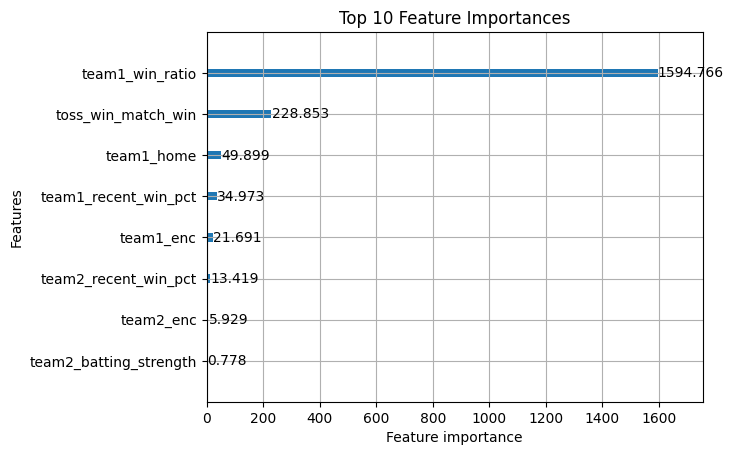

In [99]:
import matplotlib.pyplot as plt
lgb.plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.show()
